# Point vortex in potential flow

In [10]:
using Pkg
Pkg.activate("/Users/beckers/Google Drive/Academic/UCLA/CodingInProgress/ViscousFlow.jl");
using ViscousFlow
using Plots
using LinearAlgebra
using DifferentialEquations
# pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [11]:
mutable struct Vortex
    x::Real
    y::Real
    Γ::Real
end

In [12]:
function advect!(p::Vortex, u::Real, v::Real , Δt::Float64) where T
#     print("current position: $(p.x)\n")
#     print("velocity: $(v)\n")
#     print("updated position: $(p.x .+ v.*Δt)\n")
    p.x += u*Δt
    p.y += v*Δt
end

advect! (generic function with 1 method)

### Eulerian grid

In [13]:
nx = 128; ny = 128;
Lx = 2.0;
dx = Lx/(nx-2);
display(dx)
w = Nodes(Dual,(nx,ny));
ψ = Nodes(Dual,w);
L = plan_laplacian(size(w),with_inverse=true)

0.015873015873015872

Discrete Laplacian (and inverse) on a (nx = 128, ny = 128) grid with spacing 1.0

### Lagrangian points

In [14]:
n = 1

R = 0.1
body = Ellipse(R,R,n)

# Find the minimum arc length
ds = minimum(Bodies.dlength(body))

# Move the circle
xc = 1.0; yc = 1.0
T = RigidTransform((xc,yc),0.0)
T(body)

X = VectorData(body.x,body.y)
f = ScalarData(X);
ψb = ScalarData(X);

In [15]:
oB = zeros(size(f))
oB .= 1;
L⁻¹(w::T) where {T} = L\w;

### Problem parameters

In [19]:
# The desired streamfunction on the circle surface
ψb .= 1

# The desired circulation about the circle
Γ0 = 0;

# Add point vortex
vortex_1 = Vortex(1.0+dx/3,1.0+dx/3,1.0)
# vortex_2 = Vortex(1.0,1.0+dx*10,1.0)

vortices = Array{Vortex,1}()
push!(vortices,vortex_1)
# push!(vortices,vortex_2)

# vortices_loc = VectorData([vortex_1.x],[vortex_1.y])
# vortices_Γ = ScalarData([vortex_1.Γ])
# vortices_loc = VectorData([vortex_1.x,vortex_2.x],[vortex_1.y,vortex_2.y])
# vortices_Γ = VectorData([vortex_1.Γ,vortex_2.Γ])

tloc = 0.0

0.0

### Time marching

In [20]:
Δt = 1e-2;
tf = 10;#0.25
t = tloc:Δt:tf

trajectories_x = [vortex.x for vortex in vortices]
trajectories_y = [vortex.y for vortex in vortices]

vel = VectorData

for tloc in t
    
    vortices_loc = VectorData([vortex.x for vortex in vortices],[vortex.y for vortex in vortices])
    vortices_Γ = ScalarData([vortex.Γ for vortex in vortices])
    
    # Regularize vorticity to grid
    Hw = Regularize(vortices_loc,dx;ddftype=Fields.M4prime,issymmetric=true)
    Hw(w,vortices_Γ)
#     w /= dx^2
    
    # Solve potential flow
    E = Regularize(X,dx;issymmetric=true);
    Hmat,Emat = RegularizationMatrix(E,f,w);
    PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true);
    S = Matrix(PS.S);
    S₀ = transpose(oB)*(S\oB);
    T = S - oB*transpose(oB)/S₀;
    f .= S\(T*(S\(Emat*(L\w).+ψb)) .+ Γ0*oB/S₀);
    ψ₀ = -1/S₀*(Γ0 - transpose(oB)*(S\(Emat*(L\w).+ψb)));
    ψ .= -(L\(Hmat*f))-(L\(w)) .+ ψ₀; 
    
    # Calculate velocity field
    q = curl(ψ);
    
    # Interpolate velocity to point vortex
    vel = Hw(vortices_loc,q)
#     display(vel)
    
    # Update position of vortex
    for i in size(vortices)
        advect!(vortices[i],vel.u[i],vel.v[i],Δt)
        push!(trajectories_x,vortices[i].x)
        push!(trajectories_y,vortices[i].y)
    end
    
#     # Add position of vortex to trajectory
#     push!(trajectories_x,[vortex.x for vortex in vortices])
#     push!(trajectories_y,[vortex.y for vortex in vortices])
    
end

trajectories_x = reshape(trajectories_x,:,size(vortices,1));
trajectories_y = reshape(trajectories_y,:,size(vortices,1));

### Plot results

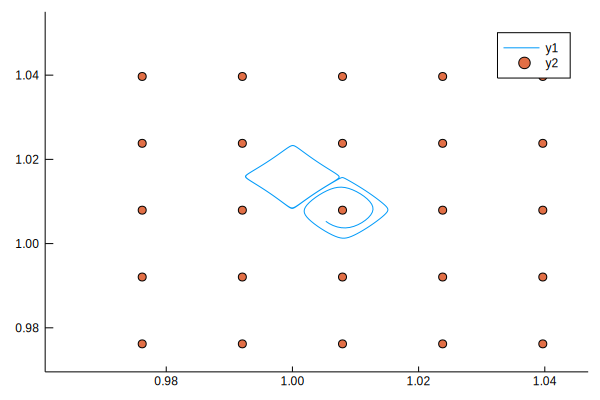

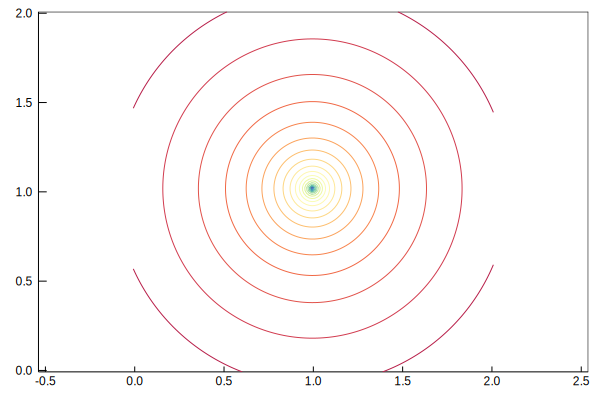

In [21]:
xg,yg = coordinates(ψ,dx=dx)
coord = [(x,y) for x in xg, y in yg]
p1 = plot(trajectories_x,trajectories_y);
scatter!(first.(coord)[:],last.(coord)[:])
xlims!(minimum(trajectories_x)-2*dx,maximum(trajectories_x)+2*dx)
ylims!(minimum(trajectories_y)-2*dx,maximum(trajectories_y)+2*dx)
p4 = plot(xg,yg,ψ,levels=20);
# plot!(body,fillcolor=:black,fillrange=0,fillalpha=0.25,linecolor=:black);
# plot!(xlims=(0.75,1.25),ylims=(1.4,1.6))

display(p1)
display(p4)
# savefig("trajectory_one_vortex_1_1-75_50.pdf")

In [22]:
vel

1 points of vector-valued data
1×2 Array{Float64,2}:
 0.0522409  0.0490885

In [42]:
show(IOContext(stdout, :compact => true,:limit => false), "text/plain", w)

Nodes{Dual,32,32} data
Printing in grid orientation (lower left is (1,1))
32×32 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0        0.0       0.0       0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0        0.0       0.0       0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0        0.0       0.0       0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0        0.0       0.0       0.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.877959  -7.89974  -7.92057   0.879852  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [34]:
vortices

1-element Array{Vortex,1}:
 Vortex(1.0, 1.0, 1.0)

In [36]:
VectorData([vortex.x for vortex in vortices],[vortex.y for vortex in vortices])

1 points of vector-valued data
1×2 Array{Float64,2}:
 1.0  1.0

In [44]:
vortices[:]

1-element Array{Vortex,1}:
 Vortex(1.0, 1.0, 1.0)

In [17]:
vel.u[1]

0.0

128×128 Array{Tuple{Float64,Float64},2}:
 (-0.00793651, -0.00793651)  …  (-0.00793651, 2.00794)
 (0.00793651, -0.00793651)      (0.00793651, 2.00794) 
 (0.0238095, -0.00793651)       (0.0238095, 2.00794)  
 (0.0396825, -0.00793651)       (0.0396825, 2.00794)  
 (0.0555556, -0.00793651)       (0.0555556, 2.00794)  
 (0.0714286, -0.00793651)    …  (0.0714286, 2.00794)  
 (0.0873016, -0.00793651)       (0.0873016, 2.00794)  
 (0.103175, -0.00793651)        (0.103175, 2.00794)   
 (0.119048, -0.00793651)        (0.119048, 2.00794)   
 (0.134921, -0.00793651)        (0.134921, 2.00794)   
 (0.150794, -0.00793651)     …  (0.150794, 2.00794)   
 (0.166667, -0.00793651)        (0.166667, 2.00794)   
 (0.18254, -0.00793651)         (0.18254, 2.00794)    
 ⋮                           ⋱                        
 (1.83333, -0.00793651)         (1.83333, 2.00794)    
 (1.84921, -0.00793651)         (1.84921, 2.00794)    
 (1.86508, -0.00793651)         (1.86508, 2.00794)    
 (1.88095, -0.00793651) 

In [113]:
minimum(trajectories_x)

1.0081339438013925

In [110]:
?min

search: min minmax minimum minimum! argmin eigmin Main typemin findmin findmin!



```
min(x, y, ...)
```

Return the minimum of the arguments. See also the [`minimum`](@ref) function to take the minimum element from a collection.

# Examples

```jldoctest
julia> min(2, 5, 1)
1
```
